In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [74]:
df = pd.read_csv("Titanic-Dataset.csv")

1. DATA CLEANING

1.1 How dataframe looks like?

In [75]:
print("Initial shape:", df.shape)
print()

print("Data Types:\n", df.dtypes)
print()

print("Missing Values:\n", df.isna().sum())
print()

# printing some values to get to know how the dataframe looks like
# not using standar HEAD method here, iloc helps to access dataframe as a dictionary item
for i in range(5): 
    print(df.iloc[i])
    print()

Initial shape: (891, 12)

Data Types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                               22.0
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                

1.2 Handling of missing values

In [76]:
clean_df = df.copy() # creating a copy so that OG remains intact

# Age: filled with Median (an imputation technique)
# -> BUT FOUND DEPENDENT ON PCLASS & thus done accordingly
clean_df["Age"] = clean_df.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)

# Embarked: filled with Mode (an imputation technique)
clean_df["Embarked"] = clean_df["Embarked"].fillna(clean_df["Embarked"].mode()[0])

# Cabin: Missing indicator method
clean_df["Cabin_Missing"] = clean_df["Cabin"].isna().astype(int)
clean_df.drop("Cabin", axis=1, inplace=True)

# verifying if everything was handled
print(clean_df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Missing    0
dtype: int64


1.3 Finding and removing duplicates

In [77]:
pre_df = clean_df.shape[0]
clean_df = clean_df.drop_duplicates(
    subset=["Name", "Pclass", "Age", "Fare"], keep="first"
)
print("Duplicates removed: {pre_df - clean_df.shape[0]}")

Duplicates removed: {pre_df - clean_df.shape[0]}


1.4 Analysing dataset for quartiles and whether we need to clip out outliers

In [78]:
print(clean_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Cabin_Missing'],
      dtype='object')


In [79]:
import pandas as pd

mylen = len(clean_df)

def mymean(name):
    return clean_df[name].sum() / len(clean_df[name])

def stddev(name):
    valid_values = clean_df[name].dropna()
    mean = mymean(name)
    count = len(valid_values)

    if count > 1:
        return ((valid_values - mean) ** 2).sum() / (count - 1) ** 0.5
    return 0

def quartiles(name):
    valid_values = clean_df[name].dropna().astype(float).tolist()
    valid_values.sort()

    n = len(valid_values)

    def get_median(data):
        m = len(data)
        if m % 2 == 0:
            return (data[m // 2] + data[m // 2 - 1]) / 2
        return data[m // 2]

    median = get_median(valid_values)
    q1 = get_median(valid_values[: n // 2])
    q3 = get_median(valid_values[(n + 1) // 2 :])

    return median, q1, q3


def cap_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[col].clip(lower, upper)


In [80]:
for col in ["Age", "Fare", "SibSp"]:
    print(f"\nStats for {col}")
    print("Mean:", mymean(col))
    print("Std dev:", stddev(col))

    med, q1, q3 = quartiles(col)
    print("25th quartile:", q1)
    print("50th quartile:", med)
    print("75th quartile:", q3)


clean_df["Fare"] = cap_outliers(clean_df, "Fare")
clean_df["Age"] = cap_outliers(clean_df, "Age")
clean_df["SibSp"] = cap_outliers(clean_df, "SibSp")



Stats for Age
Mean: 29.11242424242424
Std dev: 5280.647308985406
25th quartile: 21.5
50th quartile: 26.0
75th quartile: 36.0

Stats for Fare
Mean: 32.204207968574636
Std dev: 73670.38291098535
25th quartile: 7.8958
50th quartile: 14.4542
75th quartile: 31.0

Stats for SibSp
Mean: 0.5230078563411896
Std dev: 36.278052345265145
25th quartile: 0.0
50th quartile: 0.0
75th quartile: 1.0


1.5 Standardizing categorical values

In [81]:
clean_df["Embarked"]

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [82]:
clean_df["Sex"] = clean_df["Sex"].str.lower().str.strip()
clean_df["Embarked"] = clean_df["Embarked"].str.upper().str.strip()

# mapping short forms of embarked ports {Titanic context was used here}
port_mapping = {"S": "SOUTHAMPTON", "C": "CHERBOURG", "Q": "QUEENSTOWN"}
clean_df["Embarked"] = clean_df["Embarked"].map(port_mapping)

2. Exploratory Data Analysis

2.1 Univariate Analysis

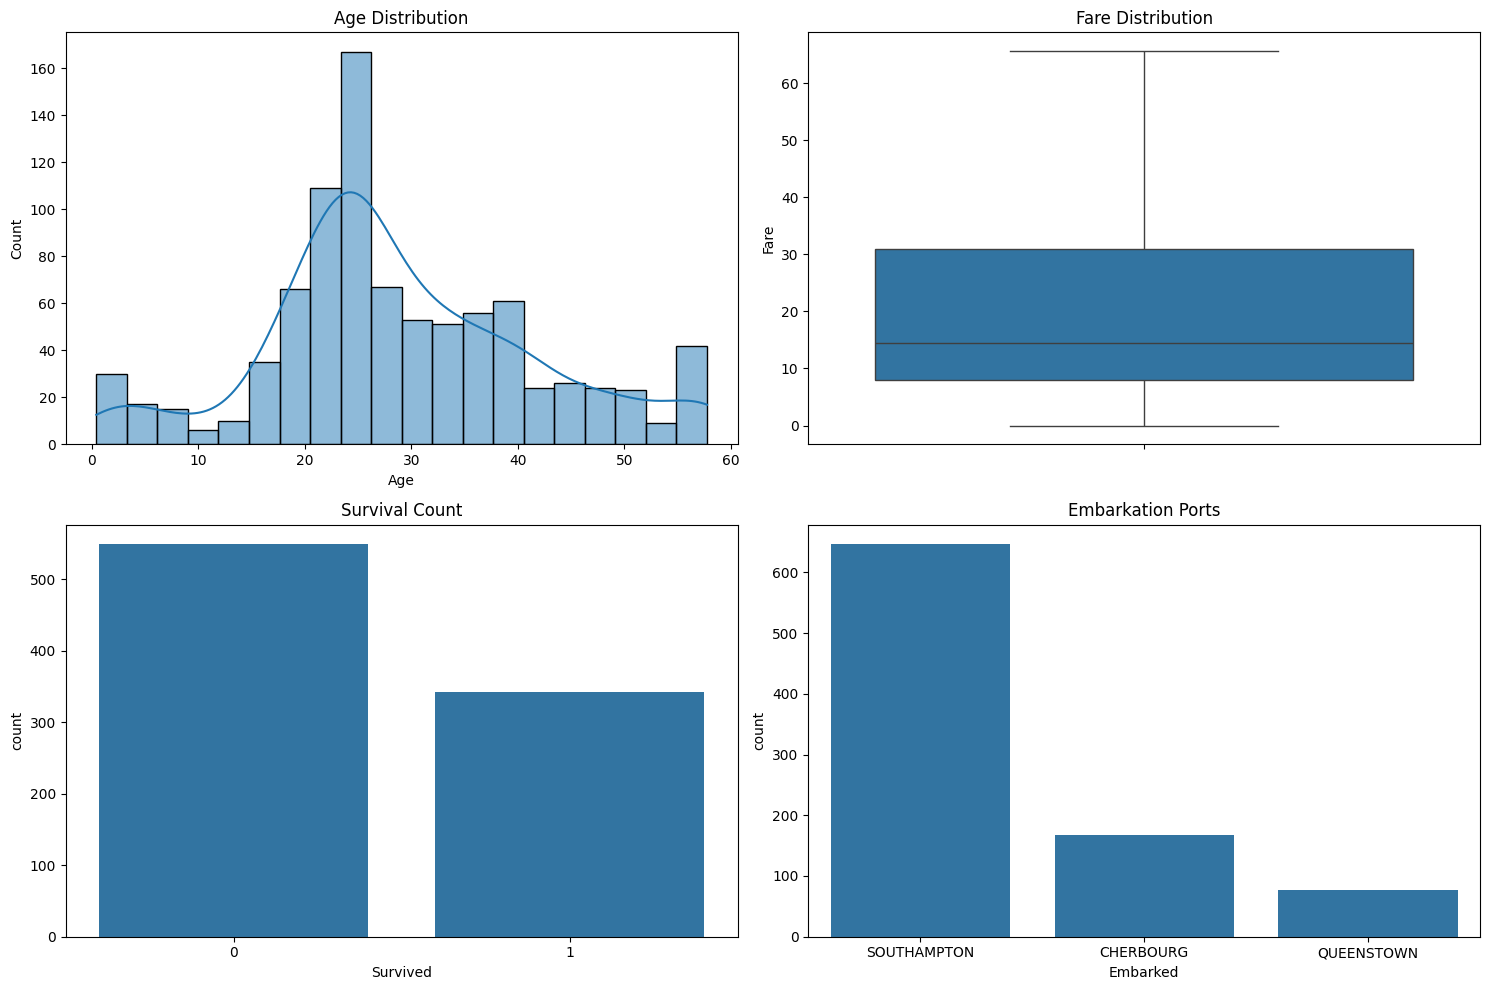

Summary:
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   28.893850    0.426487   
std     257.353842    0.486592    0.836071   12.732352    0.708246   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   21.500000    0.000000   
50%     446.000000    0.000000    3.000000   26.000000    0.000000   
75%     668.500000    1.000000    3.000000   36.000000    1.000000   
max     891.000000    1.000000    3.000000   57.750000    2.500000   

            Parch        Fare  Cabin_Missing  
count  891.000000  891.000000     891.000000  
mean     0.381594   24.046813       0.771044  
std      0.806057   20.481625       0.420397  
min      0.000000    0.000000       0.000000  
25%      0.000000    7.910400       1.000000  
50%      0.000000   14.454200       1.000000  
75%      0.000000   31.000000 

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Age Distribution
sns.histplot(clean_df["Age"], kde=True, ax=ax[0, 0], bins=20)
ax[0, 0].set_title("Age Distribution")

# Fare Boxplot
sns.boxplot(y="Fare", data=clean_df, ax=ax[0, 1])
ax[0, 1].set_title("Fare Distribution")

# Survival Count
sns.countplot(x="Survived", data=clean_df, ax=ax[1, 0])
ax[1, 0].set_title("Survival Count")

# Embarked Distribution
sns.countplot(x="Embarked", data=clean_df, ax=ax[1, 1])
ax[1, 1].set_title("Embarkation Ports")

plt.tight_layout()
plt.show()

print("Summary:\n", clean_df.describe())

2.2 Bivariate Analysis

Text(0.5, 1.0, 'Numeric Variable Correlations')

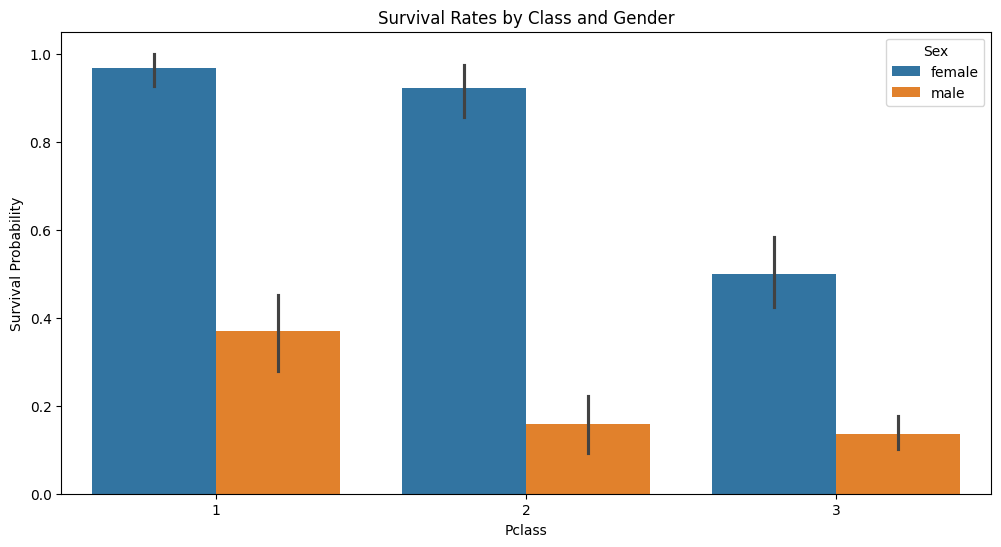

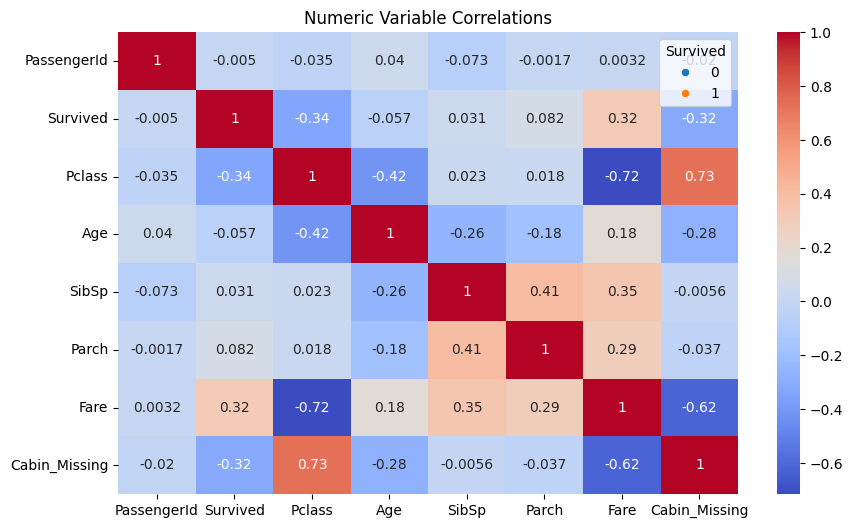

In [ ]:
# Survival by Class and Gender
plt.figure(figsize=(12, 6))
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=clean_df)
plt.title("Survival Rates by Class and Gender")
plt.ylabel("Survival Probability")

# Age vs Fare
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Age", y="Fare", hue="Survived", data=clean_df)
plt.title("Age-Fare Relationship with Survival Annotation")

# the corresponding corelation matrix -> all n^2 pair of var related at once
corr_matrix = clean_df.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Numeric Variable Correlations")

2.3 Multivariate Analysis

Chi-Square Test P-value: 4.5493e-23


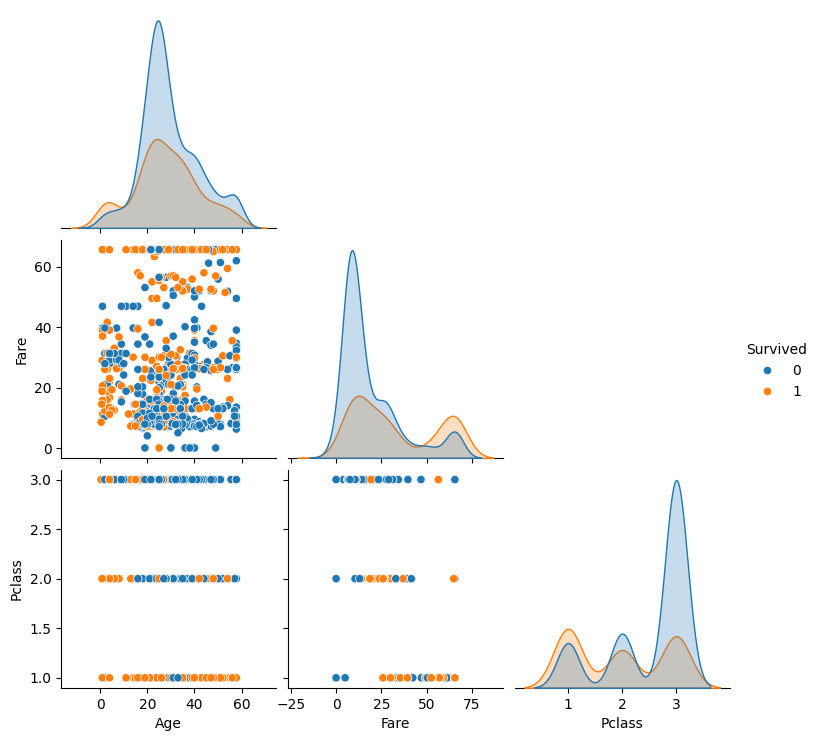

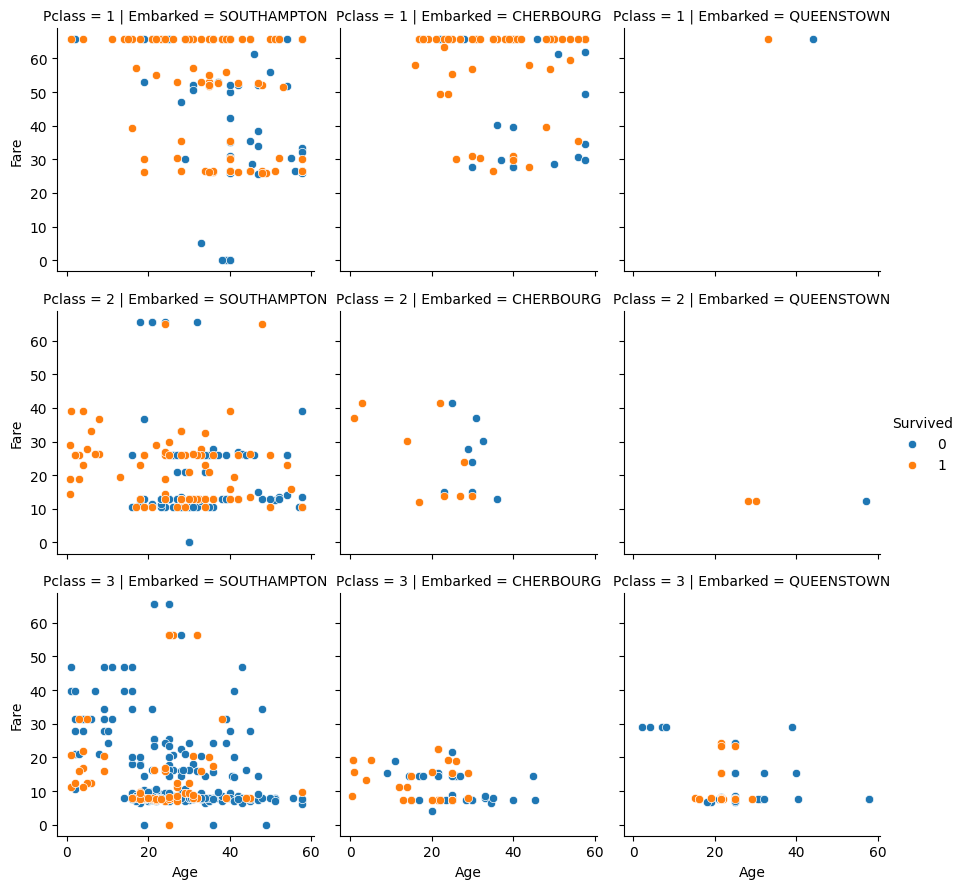

In [85]:
sns.pairplot(clean_df[["Age", "Fare", "Pclass", "Survived"]], hue="Survived", corner=True)

grid = sns.FacetGrid(clean_df, col="Embarked", row="Pclass", hue="Survived")
grid.map(sns.scatterplot, "Age", "Fare").add_legend()

class_survival = pd.crosstab(clean_df["Pclass"], clean_df["Survived"])
chi2, p, dof, expected = stats.chi2_contingency(class_survival)
print(f"Chi-Square Test P-value: {p:.4e}")